<a href="https://colab.research.google.com/github/BaldeepSinghBali/Heart-rate-detection/blob/main/Main_Heart_rate_predicition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/MahdiFarvardin/MEDVSE.git

Cloning into 'MEDVSE'...
remote: Enumerating objects: 246, done.
remote: Counting objects: 100% (118/118), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 246 (delta 53), reused 96 (delta 41), pack-reused 128 (from 1)
Receiving objects: 100% (246/246), 2.26 MiB | 6.82 MiB/s, done.
Resolving deltas: 100% (83/83), done.


In [2]:
import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers

DATA_PATH = './MEDVSE/MTHS/Data'
FS_SIGNAL = 30

WINDOW_SEC = 10
STRIDE_SEC = 1
WINDOW = FS_SIGNAL * WINDOW_SEC
STRIDE = FS_SIGNAL * STRIDE_SEC

TEST_SIZE = 0.2
SEED = 42

F_LOW, F_HIGH = 0.7, 3.0

np.random.seed(SEED)
tf.random.set_seed(SEED)

print("GPU available:", tf.config.list_physical_devices('GPU'))


GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Data Loading

In [3]:
def load_mths_data(path):
    subjects = []
    for sig_file in sorted(glob.glob(os.path.join(path, 'signal_*.npy'))):
        pid = os.path.basename(sig_file).split('_')[1].split('.')[0]
        lbl_file = os.path.join(path, f'label_{pid}.npy')
        if not os.path.exists(lbl_file):
            continue

        sig = np.load(sig_file)
        lbl = np.load(lbl_file)

        if sig.ndim == 2 and sig.shape[0] == 3:
            sig = sig.T

        subjects.append({"id": pid, "signal": sig, "label": lbl})
    return subjects

subjects = load_mths_data(DATA_PATH)
print("Loaded subjects:", len(subjects))

Loaded subjects: 62


# Data Inspection

In [4]:
for s in subjects[:3]:
    print(f"ID={s['id']} | signal={s['signal'].shape} | label={s['label'].shape}")

durations = [
    min(len(s["signal"])//FS_SIGNAL, len(s["label"]))
    for s in subjects
]
pd.Series(durations).describe()

ID=10 | signal=(1800, 3) | label=(60, 2)
ID=11 | signal=(1770, 3) | label=(59, 2)
ID=12 | signal=(2670, 3) | label=(89, 2)


,0
count,62.000000
mean,74.951613
std,26.615925
min,26.000000
25%,60.000000
50%,60.000000
75%,86.500000
max,134.000000


# Data Processing

In [5]:
def normalize_subject_signal(sig):
    mu = sig.mean(axis=0, keepdims=True)
    sd = sig.std(axis=0, keepdims=True) + 1e-8
    return (sig - mu) / sd

def make_windows(sig, lbl, sid):
    if sig.ndim != 2 or lbl.ndim != 2:
        return None
    if sig.shape[1] != 3:
        sig = sig.T

    sig = np.clip(sig, 0, 255).astype(np.float32)
    hr = lbl[:,0].astype(np.float32)

    total_sec = min(len(sig)//FS_SIGNAL, len(hr))
    if total_sec < WINDOW_SEC:
        return None

    sig = normalize_subject_signal(sig[:total_sec*FS_SIGNAL])
    hr = hr[:total_sec]
    hr_base = hr.mean()

    X, y_delta, y_abs, base = [], [], [], []
    for st in range(0, len(sig)-WINDOW+1, STRIDE):
        en = st + WINDOW
        w = sig[st:en]
        s0 = st//FS_SIGNAL
        s1 = s0 + WINDOW_SEC
        y = hr[s0:s1].mean()

        X.append(w)
        y_abs.append(y)
        y_delta.append(y - hr_base)
        base.append(hr_base)

    return {
        "X": np.stack(X),
        "y_delta": np.array(y_delta),
        "y_abs": np.array(y_abs),
        "base": np.array(base),
        "g": np.array([sid]*len(y_delta))
    }

def build_dataset(subjects):
    Xs, yd, ya, b, g = [], [], [], [], []
    for s in subjects:
        out = make_windows(s["signal"], s["label"], s["id"])
        if out is None: continue
        Xs.append(out["X"])
        yd.append(out["y_delta"])
        ya.append(out["y_abs"])
        b.append(out["base"])
        g.append(out["g"])

    return (
        np.concatenate(Xs),
        np.concatenate(yd),
        np.concatenate(ya),
        np.concatenate(b),
        np.concatenate(g)
    )

X, y_delta, y_abs, base, groups = build_dataset(subjects)
print("Final X:", X.shape)

Final X: (4089, 300, 3)


# Exploratory Data Analysis (EDA)

--- Exploratory Data Analysis ---


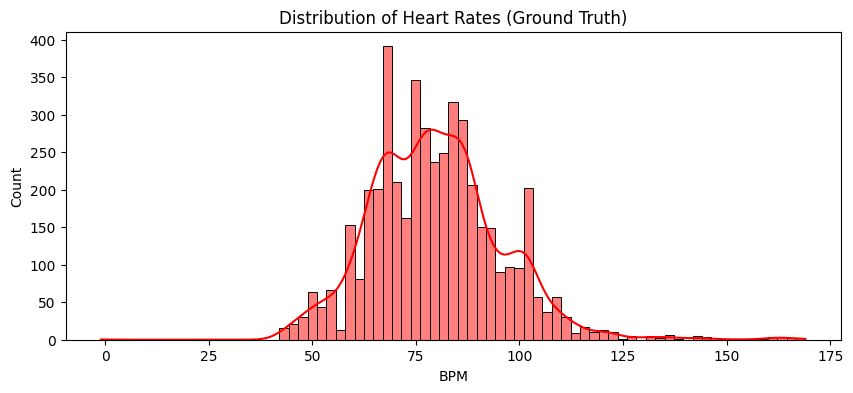

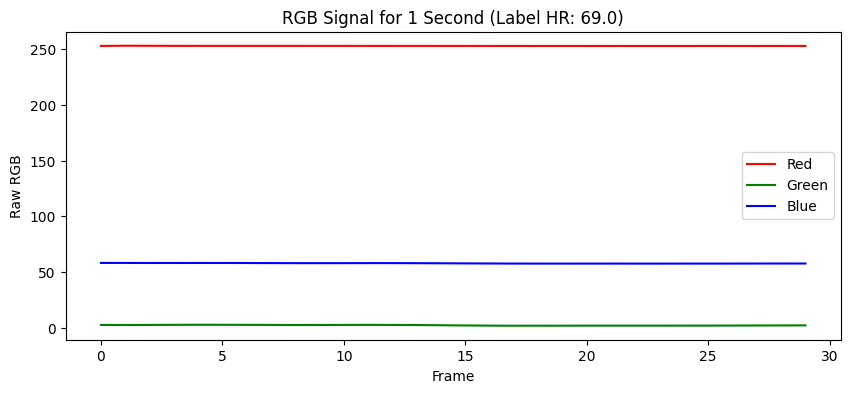

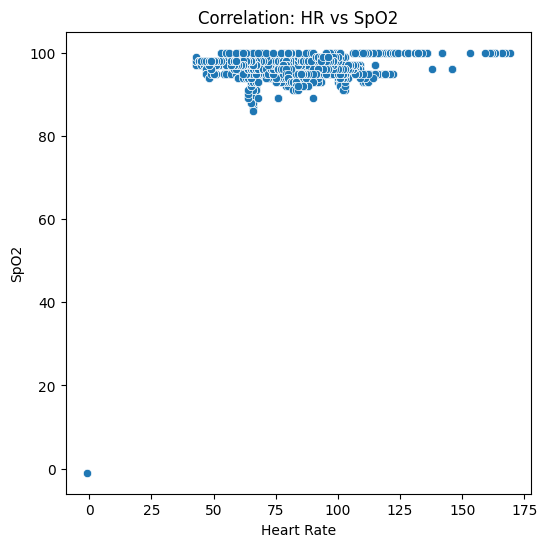

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def perform_eda_subjectwise(subjects, fs_signal=30, sample_subject_idx=0, sample_second=0):
    print("--- Exploratory Data Analysis ---")

    hr_all = []
    spo2_all = []

    for s in subjects:
        lbl = np.asarray(s["label"])
        if lbl.ndim == 2 and lbl.shape[1] >= 2:
            hr_all.append(lbl[:, 0])
            spo2_all.append(lbl[:, 1])

    hr_all = np.concatenate(hr_all)
    spo2_all = np.concatenate(spo2_all)

    plt.figure(figsize=(10, 4))
    sns.histplot(hr_all, kde=True, color='red')
    plt.title('Distribution of Heart Rates (Ground Truth)')
    plt.xlabel('BPM')
    plt.show()

    s = subjects[sample_subject_idx]
    sig = np.asarray(s["signal"])
    lbl = np.asarray(s["label"])

    if sig.ndim == 2 and sig.shape[0] == 3:
        sig = sig.T

    start = sample_second * fs_signal
    end = start + fs_signal

    if sig.ndim != 2 or sig.shape[1] != 3 or end > len(sig):
        print("Cannot plot RGB window — check signal shape or length.")
    else:
        window = sig[start:end]

        hr_value = lbl[sample_second, 0] if sample_second < len(lbl) else np.nan

        plt.figure(figsize=(10, 4))
        plt.plot(window[:, 0], color='r', label='Red')
        plt.plot(window[:, 1], color='g', label='Green')
        plt.plot(window[:, 2], color='b', label='Blue')
        plt.title(f'RGB Signal for 1 Second (Label HR: {hr_value:.1f})')
        plt.xlabel('Frame')
        plt.ylabel('Raw RGB')
        plt.legend()
        plt.show()

    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=hr_all, y=spo2_all)
    plt.title('Correlation: HR vs SpO2')
    plt.xlabel('Heart Rate')
    plt.ylabel('SpO2')
    plt.show()

perform_eda_subjectwise(
    subjects,
    fs_signal=FS_SIGNAL,
    sample_subject_idx=0,
    sample_second=0
)

# Finalize X, Y and Train-Test Split

In [7]:
gss = GroupShuffleSplit(n_splits=1, test_size=TEST_SIZE, random_state=SEED)
tr, te = next(gss.split(X, y_delta, groups))

Xtr, Xte = X[tr], X[te]
yd_tr, yd_te = y_delta[tr], y_delta[te]
ya_tr, ya_te = y_abs[tr], y_abs[te]
b_tr, b_te = base[tr], base[te]
g_te = groups[te]

print("Train subjects:", len(np.unique(groups[tr])))
print("Test subjects:", len(np.unique(groups[te])))

Train subjects: 49
Test subjects: 13


In [8]:
def bandpower_features(X):
    feats = []
    freqs = np.fft.rfftfreq(X.shape[1], d=1/FS_SIGNAL)
    band = (freqs>=F_LOW)&(freqs<=F_HIGH)

    for w in X:
        mu = w.mean(axis=0)
        sd = w.std(axis=0)
        fft = np.abs(np.fft.rfft(w, axis=0))[band]
        bp = fft.mean(axis=0)
        peak = freqs[band][fft.argmax(axis=0)]
        feats.append(np.concatenate([mu, sd, bp, peak]))
    return np.array(feats)

Ftr = bandpower_features(Xtr)
Fte = bandpower_features(Xte)

# Model A: ML Baseline (Random Forest)

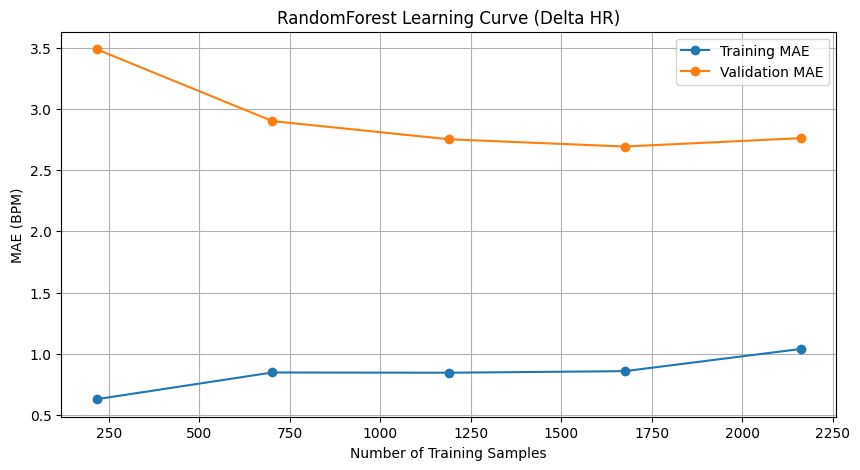

----- RandomForest Baseline Performance -----
Test MAE: 2.82 BPM


In [12]:
from sklearn.model_selection import learning_curve
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import matplotlib.pyplot as plt

rf_baseline = RandomForestRegressor(
    n_estimators=600,
    max_depth=18,
    min_samples_leaf=8,
    random_state=SEED,
    n_jobs=-1
)

train_sizes, train_scores, val_scores = learning_curve(
    rf_baseline,
    Ftr,
    yd_tr,
    cv=3,
    scoring="neg_mean_absolute_error",
    train_sizes=np.linspace(0.1, 1.0, 5),
    n_jobs=-1
)

train_mae = -np.mean(train_scores, axis=1)
val_mae = -np.mean(val_scores, axis=1)

plt.figure(figsize=(10, 5))
plt.plot(train_sizes, train_mae, 'o-', label='Training MAE')
plt.plot(train_sizes, val_mae, 'o-', label='Validation MAE')
plt.title("RandomForest Learning Curve (Delta HR)")
plt.xlabel("Number of Training Samples")
plt.ylabel("MAE (BPM)")
plt.legend()
plt.grid(True)
plt.show()

rf_baseline.fit(Ftr, yd_tr)

pred_delta_rf = rf_baseline.predict(Fte)
pred_rf = pred_delta_rf + b_te

baseline_mae = mean_absolute_error(ya_te, pred_rf)

print("----- RandomForest Baseline Performance -----")
print(f"Test MAE: {baseline_mae:.2f} BPM")

# Model B: Extra Trees

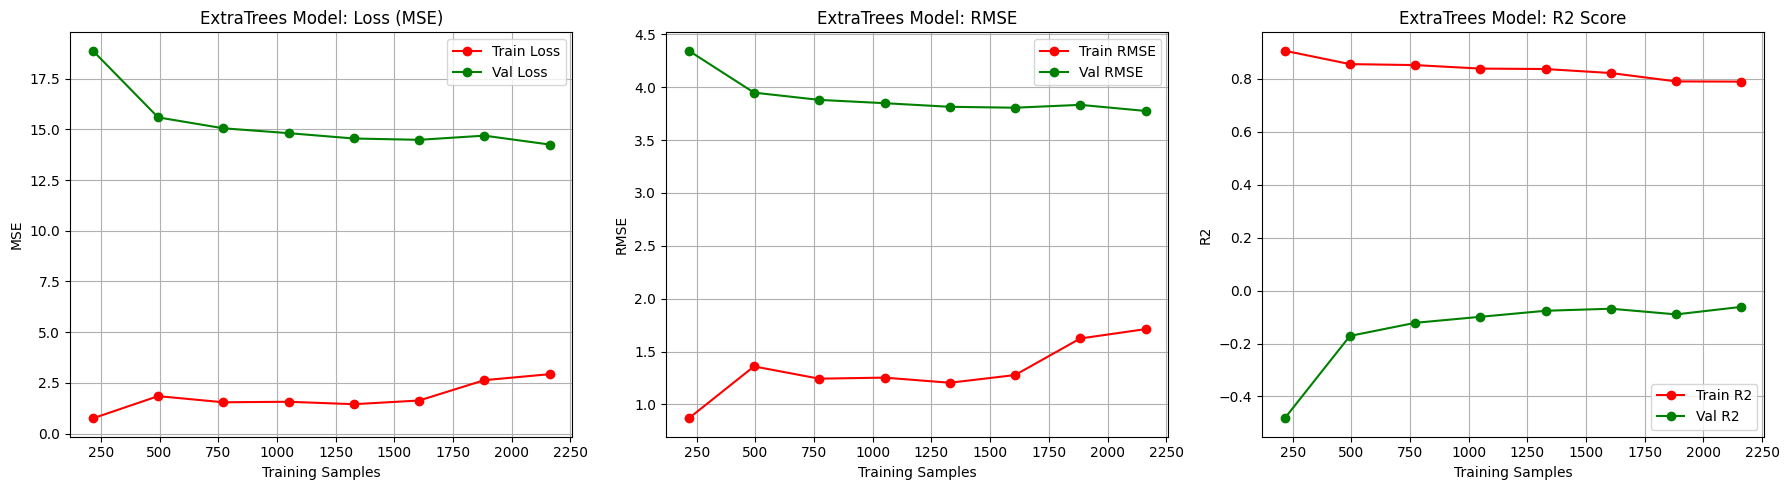

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.ensemble import ExtraTreesRegressor


et_baseline = ExtraTreesRegressor(
    n_estimators=800,
    max_depth=18,
    min_samples_leaf=6,
    random_state=SEED,
    n_jobs=-1
)

train_sizes = np.linspace(0.1, 1.0, 8)

ts_mse, tr_mse, va_mse = learning_curve(
    et_baseline, Ftr, yd_tr,
    cv=3,
    scoring="neg_mean_squared_error",
    train_sizes=train_sizes,
    n_jobs=-1
)
tr_mse_mean = -tr_mse.mean(axis=1)
va_mse_mean = -va_mse.mean(axis=1)

tr_rmse_mean = np.sqrt(tr_mse_mean)
va_rmse_mean = np.sqrt(va_mse_mean)

ts_r2, tr_r2, va_r2 = learning_curve(
    et_baseline, Ftr, yd_tr,
    cv=3,
    scoring="r2",
    train_sizes=train_sizes,
    n_jobs=-1
)
tr_r2_mean = tr_r2.mean(axis=1)
va_r2_mean = va_r2.mean(axis=1)

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(ts_mse, tr_mse_mean, 'o-', color='red', label='Train Loss')
plt.plot(ts_mse, va_mse_mean, 'o-', color='green', label='Val Loss')
plt.title("ExtraTrees Model: Loss (MSE)")
plt.xlabel("Training Samples")
plt.ylabel("MSE")
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(ts_mse, tr_rmse_mean, 'o-', color='red', label='Train RMSE')
plt.plot(ts_mse, va_rmse_mean, 'o-', color='green', label='Val RMSE')
plt.title("ExtraTrees Model: RMSE")
plt.xlabel("Training Samples")
plt.ylabel("RMSE")
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(ts_r2, tr_r2_mean, 'o-', color='red', label='Train R2')
plt.plot(ts_r2, va_r2_mean, 'o-', color='green', label='Val R2')
plt.title("ExtraTrees Model: R2 Score")
plt.xlabel("Training Samples")
plt.ylabel("R2")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Model 3 : TCN

Epoch 1/80
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 207ms/step - loss: 0.8694 - r2_metric: -257.8710 - rmse_metric: 0.9405 - val_loss: 1.8937 - val_r2_metric: -172.5383 - val_rmse_metric: 1.2384
Epoch 2/80
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.8452 - r2_metric: -262.1089 - rmse_metric: 0.9479 - val_loss: 1.8914 - val_r2_metric: -171.1042 - val_rmse_metric: 1.2285
Epoch 3/80
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.8323 - r2_metric: -263.6740 - rmse_metric: 0.9506 - val_loss: 1.8691 - val_r2_metric: -172.0528 - val_rmse_metric: 1.2314
Epoch 4/80
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.8213 - r2_metric: -268.8053 - rmse_metric: 0.9596 - val_loss: 1.8783 - val_r2_metric: -172.8038 - val_rmse_metric: 1.2352
Epoch 5/80
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.8102 - r2_metric: -270.3890 - rmse_metric: 0.9623 - val_loss: 1.8737 - val_r2_metric: -173.8043 - val_rmse_metric: 1.2397
Epoch 6/80
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.8025 - r2_metric: -273.

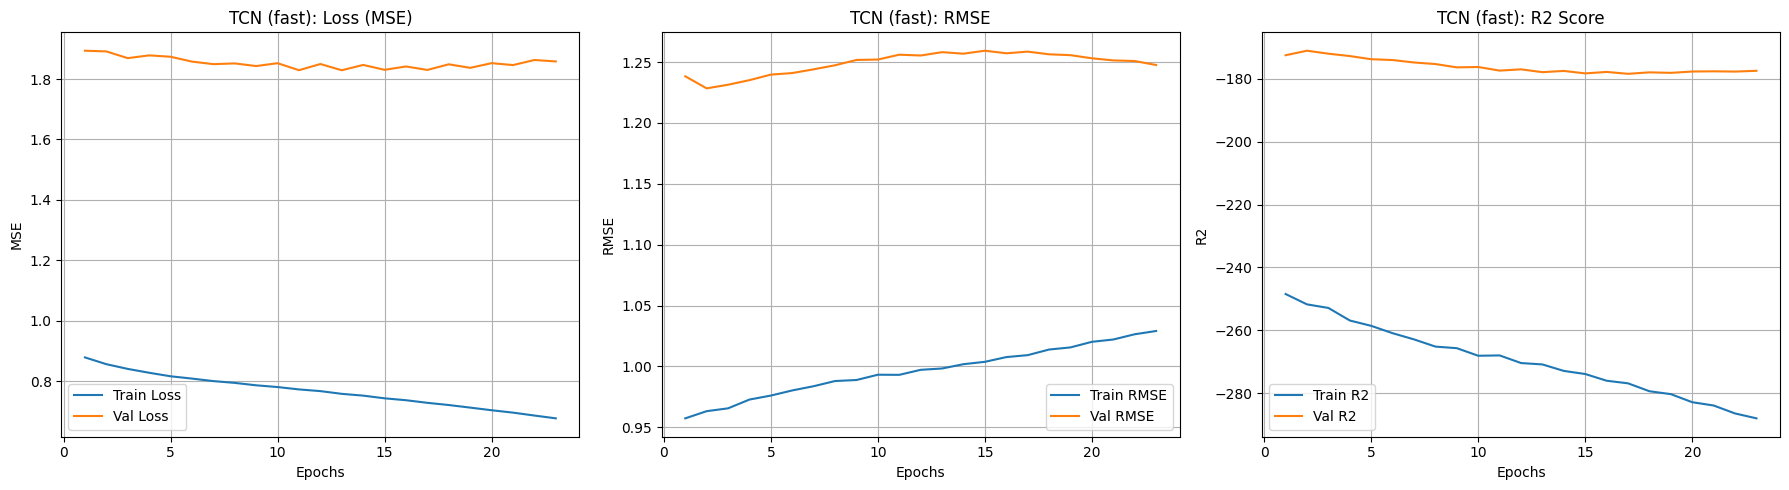

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
----- TCN Test Performance -----
MAE  : 2.71 BPM
RMSE : 3.83 BPM
R2   : 0.946


In [14]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import layers, models
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

def r2_metric(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1.0 - ss_res / (ss_tot + K.epsilon())

def rmse_metric(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_true - y_pred)))

def build_tcn(input_shape):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv1D(64, 3, padding="causal", activation="relu", dilation_rate=1)(inputs)
    x = layers.Conv1D(64, 3, padding="causal", activation="relu", dilation_rate=2)(x)
    x = layers.Conv1D(64, 3, padding="causal", activation="relu", dilation_rate=4)(x)
    x = layers.GlobalAveragePooling1D()(x)
    outputs = layers.Dense(1)(x)
    return models.Model(inputs, outputs)

tcn = build_tcn(Xtr.shape[1:])

tcn.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="mse",
    metrics=[rmse_metric, r2_metric]
)

y_scaler = StandardScaler()
yd_tr_s = y_scaler.fit_transform(yd_tr.reshape(-1, 1)).ravel()
yd_te_s = y_scaler.transform(yd_te.reshape(-1, 1)).ravel()

history_tcn = tcn.fit(
    Xtr,
    yd_tr_s,
    validation_split=0.1,
    epochs=80,
    batch_size=256,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)],
    verbose=1
)

def plot_tcn_history_like_extratrees(history, model_name="TCN"):
    h = history.history
    epochs = range(1, len(h["loss"]) + 1)

    plt.figure(figsize=(18, 5))

    plt.subplot(1, 3, 1)
    plt.plot(epochs, h["loss"], label="Train Loss")
    plt.plot(epochs, h["val_loss"], label="Val Loss")
    plt.title(f"{model_name}: Loss (MSE)")
    plt.xlabel("Epochs")
    plt.ylabel("MSE")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(epochs, h["rmse_metric"], label="Train RMSE")
    plt.plot(epochs, h["val_rmse_metric"], label="Val RMSE")
    plt.title(f"{model_name}: RMSE")
    plt.xlabel("Epochs")
    plt.ylabel("RMSE")
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.plot(epochs, h["r2_metric"], label="Train R2")
    plt.plot(epochs, h["val_r2_metric"], label="Val R2")
    plt.title(f"{model_name}: R2 Score")
    plt.xlabel("Epochs")
    plt.ylabel("R2")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_tcn_history_like_extratrees(history_tcn, "TCN (fast)")

pred_delta_tcn = y_scaler.inverse_transform(
    tcn.predict(Xte)
).ravel()

pred_tcn = pred_delta_tcn + b_te

mae_tcn = mean_absolute_error(ya_te, pred_tcn)
rmse_tcn = np.sqrt(mean_squared_error(ya_te, pred_tcn))
r2_tcn = r2_score(ya_te, pred_tcn)

print("----- TCN Test Performance -----")
print(f"MAE  : {mae_tcn:.2f} BPM")
print(f"RMSE : {rmse_tcn:.2f} BPM")
print(f"R2   : {r2_tcn:.3f}")

# Metrics On Test set

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


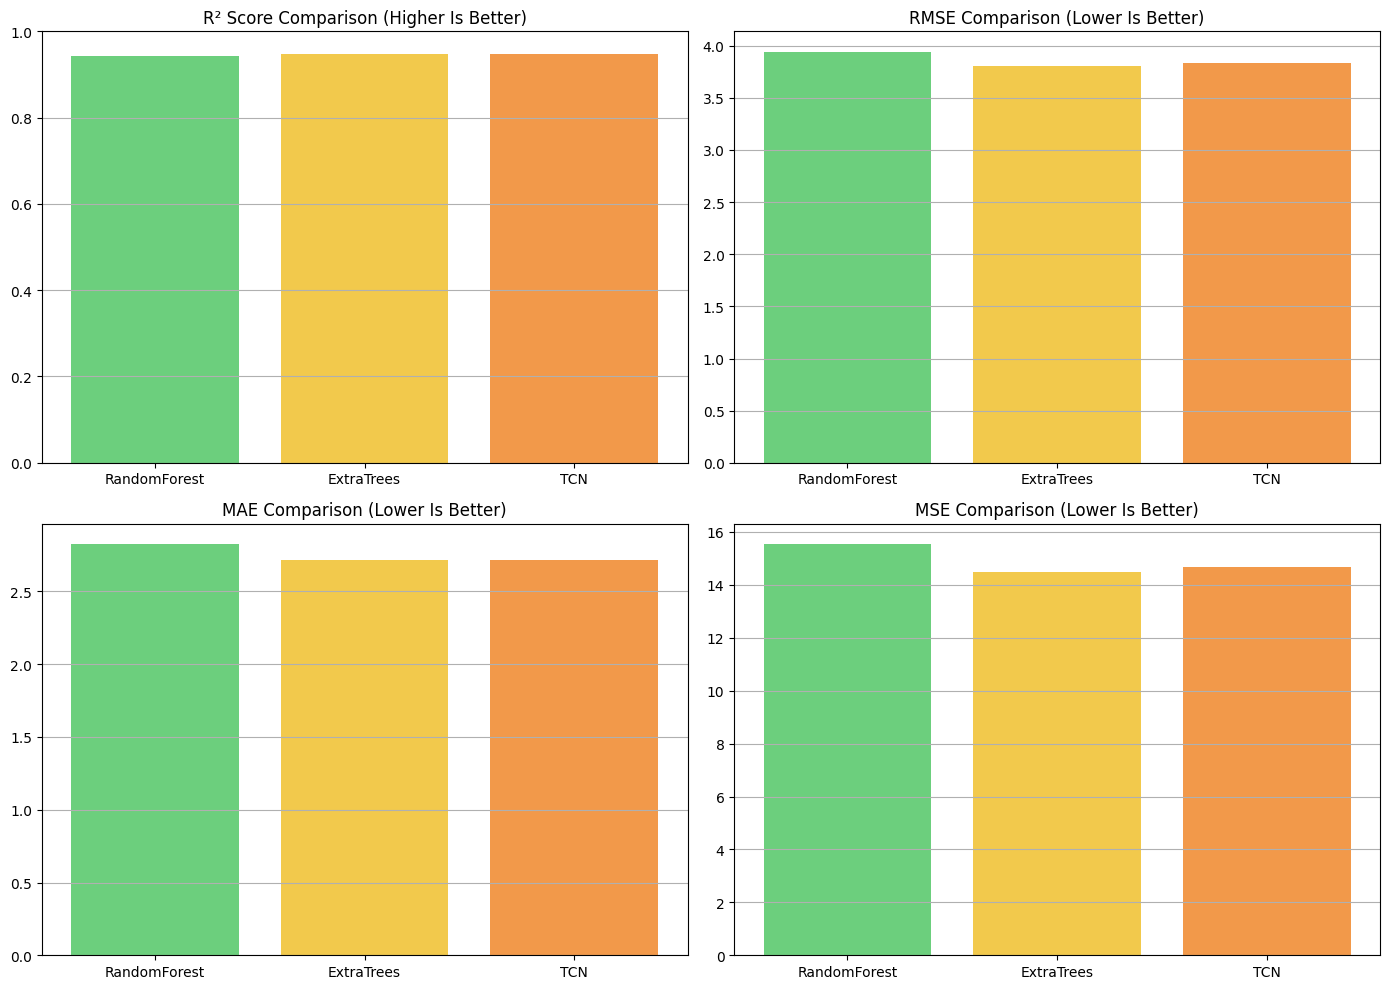


========== FINAL TEST METRICS ==========

RandomForest
  R2   : 0.943
  MAE  : 2.82 BPM
  RMSE : 3.94 BPM
  MSE  : 15.53
----------------------------------------
ExtraTrees
  R2   : 0.947
  MAE  : 2.72 BPM
  RMSE : 3.80 BPM
  MSE  : 14.47
----------------------------------------
TCN
  R2   : 0.946
  MAE  : 2.71 BPM
  RMSE : 3.83 BPM
  MSE  : 14.67
----------------------------------------


In [15]:
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

rf_model = RandomForestRegressor(
    n_estimators=600,
    max_depth=18,
    min_samples_leaf=8,
    random_state=SEED,
    n_jobs=-1
)

rf_model.fit(Ftr, yd_tr)
pred_rf = rf_model.predict(Fte) + b_te

et_model = ExtraTreesRegressor(
    n_estimators=800,
    max_depth=18,
    min_samples_leaf=6,
    random_state=SEED,
    n_jobs=-1
)

et_model.fit(Ftr, yd_tr)
pred_et = et_model.predict(Fte) + b_te

pred_delta_tcn = y_scaler.inverse_transform(
    tcn.predict(Xte)
).ravel()
pred_tcn = pred_delta_tcn + b_te

models = ["RandomForest", "ExtraTrees", "TCN"]
colors = ["#6CCF7D", "#F2C94C", "#F2994A"]

r2_scores = [
    r2_score(ya_te, pred_rf),
    r2_score(ya_te, pred_et),
    r2_score(ya_te, pred_tcn)
]

mse_scores = [
    mean_squared_error(ya_te, pred_rf),
    mean_squared_error(ya_te, pred_et),
    mean_squared_error(ya_te, pred_tcn)
]

rmse_scores = [np.sqrt(m) for m in mse_scores]

mae_scores = [
    mean_absolute_error(ya_te, pred_rf),
    mean_absolute_error(ya_te, pred_et),
    mean_absolute_error(ya_te, pred_tcn)
]

plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
plt.bar(models, r2_scores, color=colors)
plt.title("R² Score Comparison (Higher Is Better)")
plt.ylim(0, 1)
plt.grid(axis="y")

plt.subplot(2, 2, 2)
plt.bar(models, rmse_scores, color=colors)
plt.title("RMSE Comparison (Lower Is Better)")
plt.grid(axis="y")

plt.subplot(2, 2, 3)
plt.bar(models, mae_scores, color=colors)
plt.title("MAE Comparison (Lower Is Better)")
plt.grid(axis="y")

plt.subplot(2, 2, 4)
plt.bar(models, mse_scores, color=colors)
plt.title("MSE Comparison (Lower Is Better)")
plt.grid(axis="y")

plt.tight_layout()
plt.show()

metrics = {
    "RandomForest": {
        "R2": r2_score(ya_te, pred_rf),
        "MAE": mean_absolute_error(ya_te, pred_rf),
        "MSE": mean_squared_error(ya_te, pred_rf)
    },
    "ExtraTrees": {
        "R2": r2_score(ya_te, pred_et),
        "MAE": mean_absolute_error(ya_te, pred_et),
        "MSE": mean_squared_error(ya_te, pred_et)
    },
    "TCN": {
        "R2": r2_score(ya_te, pred_tcn),
        "MAE": mean_absolute_error(ya_te, pred_tcn),
        "MSE": mean_squared_error(ya_te, pred_tcn)
    }
}

for m in metrics.values():
    m["RMSE"] = np.sqrt(m["MSE"])

print("\n========== FINAL TEST METRICS ==========\n")
for model, vals in metrics.items():
    print(model)
    print(f"  R2   : {vals['R2']:.3f}")
    print(f"  MAE  : {vals['MAE']:.2f} BPM")
    print(f"  RMSE : {vals['RMSE']:.2f} BPM")
    print(f"  MSE  : {vals['MSE']:.2f}")
    print("-" * 40)

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Application

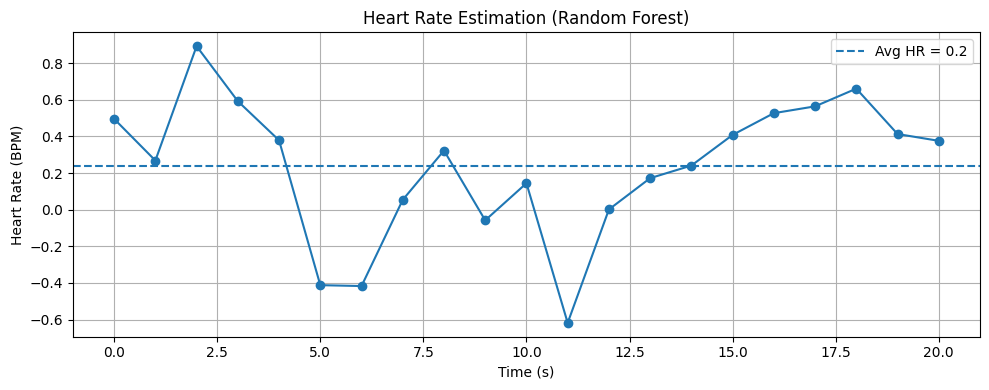

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# ===== MATCH TRAINING CONFIG =====

FS_SIGNAL = 30
WINDOW_SEC = 10
STRIDE_SEC = 1
WINDOW = FS_SIGNAL * WINDOW_SEC
STRIDE = FS_SIGNAL * STRIDE_SEC
F_LOW, F_HIGH = 0.7, 3.0
# =================================


class HeartRateMonitor:
    def __init__(self, model):
        self.model = model

    def extract_signal_from_video(self, video_path):
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            raise RuntimeError("Cannot open video")

        signal = []
        while True:
            ret, frame = cap.read()
            if not ret:
                break

            rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            h, w, _ = rgb.shape
            s = int(min(h, w) * 0.5)

            cx, cy = w // 2, h // 2
            roi = rgb[
                cy - s // 2 : cy + s // 2,
                cx - s // 2 : cx + s // 2
            ]

            signal.append(np.mean(roi, axis=(0, 1)))

        cap.release()
        return np.asarray(signal, dtype=np.float32)

    def normalize_subject_signal(self, sig):
        mu = sig.mean(axis=0, keepdims=True)
        sd = sig.std(axis=0, keepdims=True) + 1e-8
        return (sig - mu) / sd

    def make_windows(self, sig):
        return np.array([
            sig[i:i + WINDOW]
            for i in range(0, len(sig) - WINDOW + 1, STRIDE)
        ])

    def bandpower_features(self, X):
        feats = []
        freqs = np.fft.rfftfreq(X.shape[1], d=1 / FS_SIGNAL)
        band = (freqs >= F_LOW) & (freqs <= F_HIGH)

        for w in X:
            mu = w.mean(axis=0)
            sd = w.std(axis=0)
            fft = np.abs(np.fft.rfft(w, axis=0))[band]
            bp = fft.mean(axis=0)
            peak = freqs[band][fft.argmax(axis=0)]
            feats.append(np.concatenate([mu, sd, bp, peak]))

        return np.asarray(feats)

    def predict(self, video_path):
        raw = self.extract_signal_from_video(video_path)
        if len(raw) < WINDOW:
            raise RuntimeError("Video too short for inference")

        sig = self.normalize_subject_signal(np.clip(raw, 0, 255))
        Xw = self.make_windows(sig)
        F = self.bandpower_features(Xw)

        delta_hr = self.model.predict(F)
        hr = delta_hr + delta_hr.mean()

        self.plot(hr)
        return hr

    def plot(self, hr):
        t = np.arange(len(hr)) * STRIDE_SEC

        plt.figure(figsize=(10, 4))
        plt.plot(t, hr, marker="o")
        plt.axhline(hr.mean(), linestyle="--", label=f"Avg HR = {hr.mean():.1f}")
        plt.xlabel("Time (s)")
        plt.ylabel("Heart Rate (BPM)")
        plt.title("Heart Rate Estimation (Random Forest)")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

model = rf_baseline

app = HeartRateMonitor(model)
hr = app.predict("video.mp4")